### Prophet

[Prophet](https://github.com/facebook/prophet) был создан, чтобы решить следующие трудности, характерные для многих временных рядов:
- Сезонные эффекты: еженедельные, ежемесячные и годовые циклы, спады и пики в праздничные дни.
- Изменения тренда в связи с появлением новых продуктов и рыночными событиями.
- Выбросы.

Авторы утверждают, что даже при настройках по умолчанию во многих случаях их библиотека выдаёт прогнозы столь же точные, как и прогнозы опытных аналитиков.


### Модель внутри Prophet

По сути внутри аддитивная регрессионная модель

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t},$$

где:
* Тренд $g(t)$ моделирует непериодические изменения.
* Сезонность $s(t)$ представляет собой периодические изменения.
* Компонент Holidays $h(t)$ предоставляет информацию о праздниках и событиях.



### Импорты

In [ ]:
%%capture
!pip install prophet --no-binary :all:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style="darkgrid")

# sharper plots
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Подготовка данных

Будем предсказывать ежедневное количество публикаций, публикуемых на [Medium](https://medium.com/).

In [ ]:
df = pd.read_csv('medium_posts.csv')

In [ ]:
df.head()

,published,domain,url
0,2012-08-13 22:54:53.510Z,medium.com,https://medium.com/policy/medium-terms-of-serv...
1,2012-08-13 22:57:17.248Z,medium.com,https://medium.com/policy/medium-privacy-polic...
2,2016-11-04 23:40:43.364Z,medium.com,https://medium.com/@Medium/personalize-your-me...
3,2016-12-24 18:21:13.427Z,medium.com,https://medium.com/holiday-poems/xmas-morning-...
4,2015-09-22 21:37:48.207Z,blog.medium.com,https://blog.medium.com/taking-a-side-on-net-n...


In [ ]:
df = df[['published', 'url']].dropna().drop_duplicates()

In [ ]:
df['published'] = pd.to_datetime(df['published'])

In [ ]:
df.sort_values(by=['published']).head()

,published,url
50931,1970-01-01 00:00:00.001000+00:00,https://medium.com/iiot
40243,1970-01-01 00:00:00.001000+00:00,https://medium.com/@ikaella/melon-rebranding-b...
37395,1970-01-18 05:11:46.500000+00:00,http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...
37398,1970-01-18 05:11:58.200000+00:00,http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...
37394,1970-01-18 05:26:42.120000+00:00,http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...


In [ ]:
df = df[(df['published'] > '2012-08-15') & (df['published'] < '2017-06-26')].sort_values(by=['published'])
df.head()

,published,url
24630,2012-08-15 00:25:03.373000+00:00,https://medium.com/launch-day/jean-attempts-to...
24631,2012-08-15 00:25:29.419000+00:00,https://medium.com/launch-day/dan-and-kristin-...
17811,2012-08-15 00:34:59.502000+00:00,https://medium.com/i-m-h-o/the-world-is-social...
17281,2012-08-15 00:40:10.773000+00:00,https://medium.com/@karen/this-farm-table-1cfc...
12376,2012-08-15 00:58:25.898000+00:00,https://medium.com/@hattmodgins/lighting-strik...


Для предсказания количества опубликованных сообщений, сгруппируем и посчитаемуникальные сообщения в каждый данный момент времени

In [ ]:
aggr_df = df.groupby('published')[['url']].count()
aggr_df.columns = ['posts']
aggr_df.head()

,posts
published,
2012-08-15 00:25:03.373000+00:00,1
2012-08-15 00:25:29.419000+00:00,1
2012-08-15 00:34:59.502000+00:00,1
2012-08-15 00:40:10.773000+00:00,1
2012-08-15 00:58:25.898000+00:00,1


In [ ]:
daily_df = aggr_df.resample('D').apply(sum)
daily_df.head()

,posts
published,
2012-08-15 00:00:00+00:00,16
2012-08-16 00:00:00+00:00,11
2012-08-17 00:00:00+00:00,4
2012-08-18 00:00:00+00:00,2
2012-08-19 00:00:00+00:00,1


### EDA


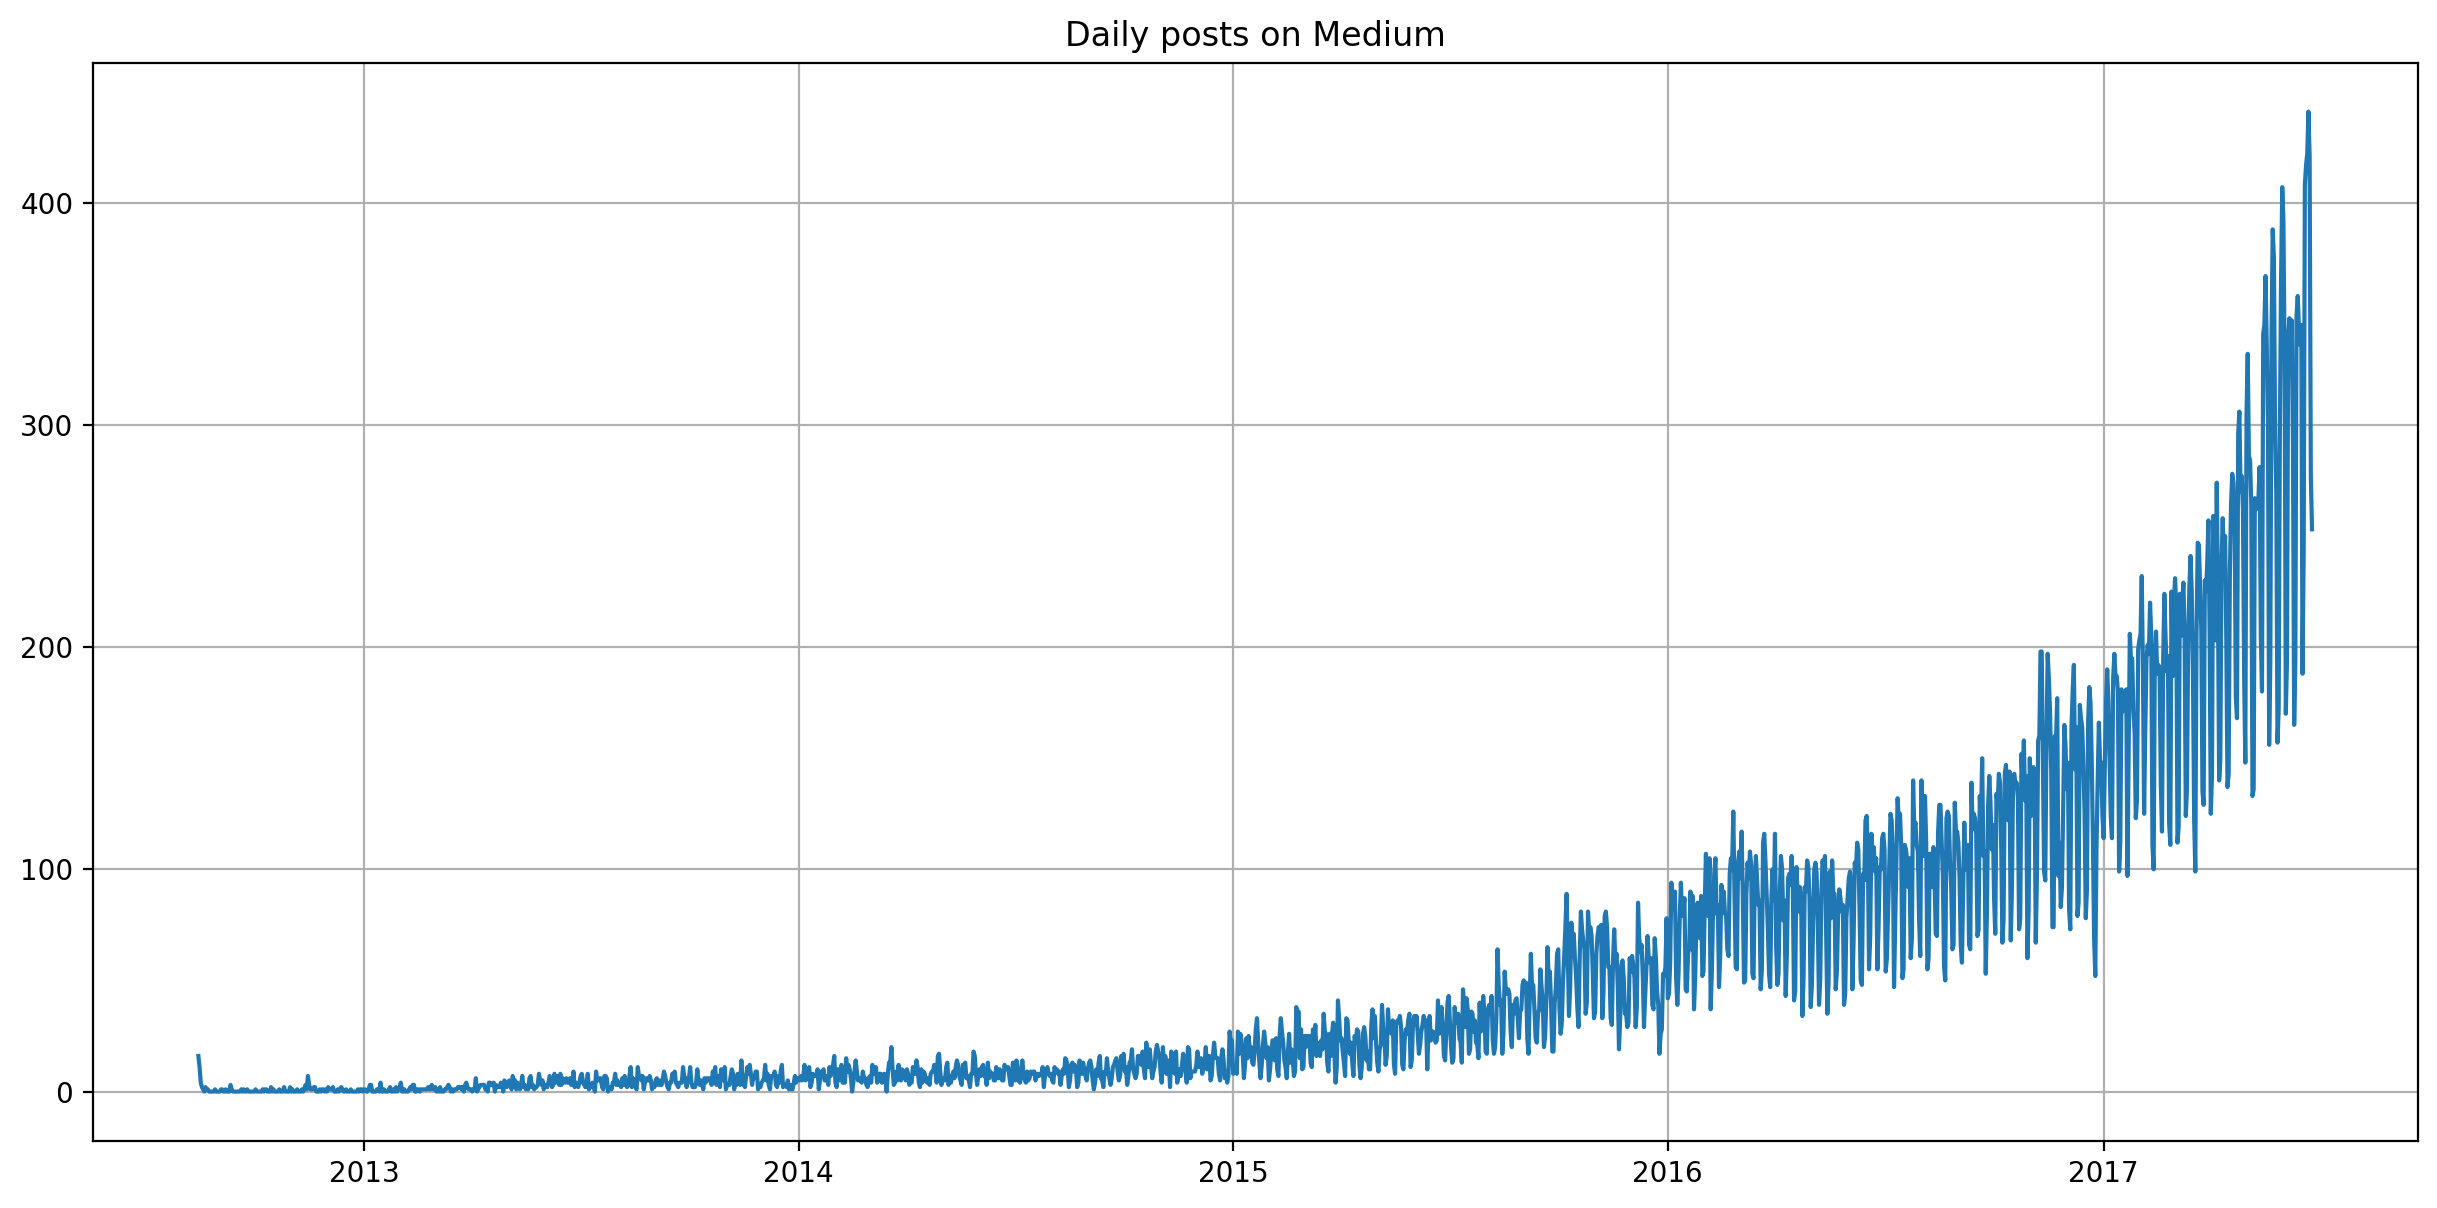

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(daily_df.posts)
plt.title('Daily posts on Medium')
plt.grid(True)
plt.show()

Чтобы чуть лучше рассмотреть данные, сделаем еще раз ресэмплинг

In [ ]:
weekly_df = daily_df.resample('W').apply(sum)

И отрисуем результаты

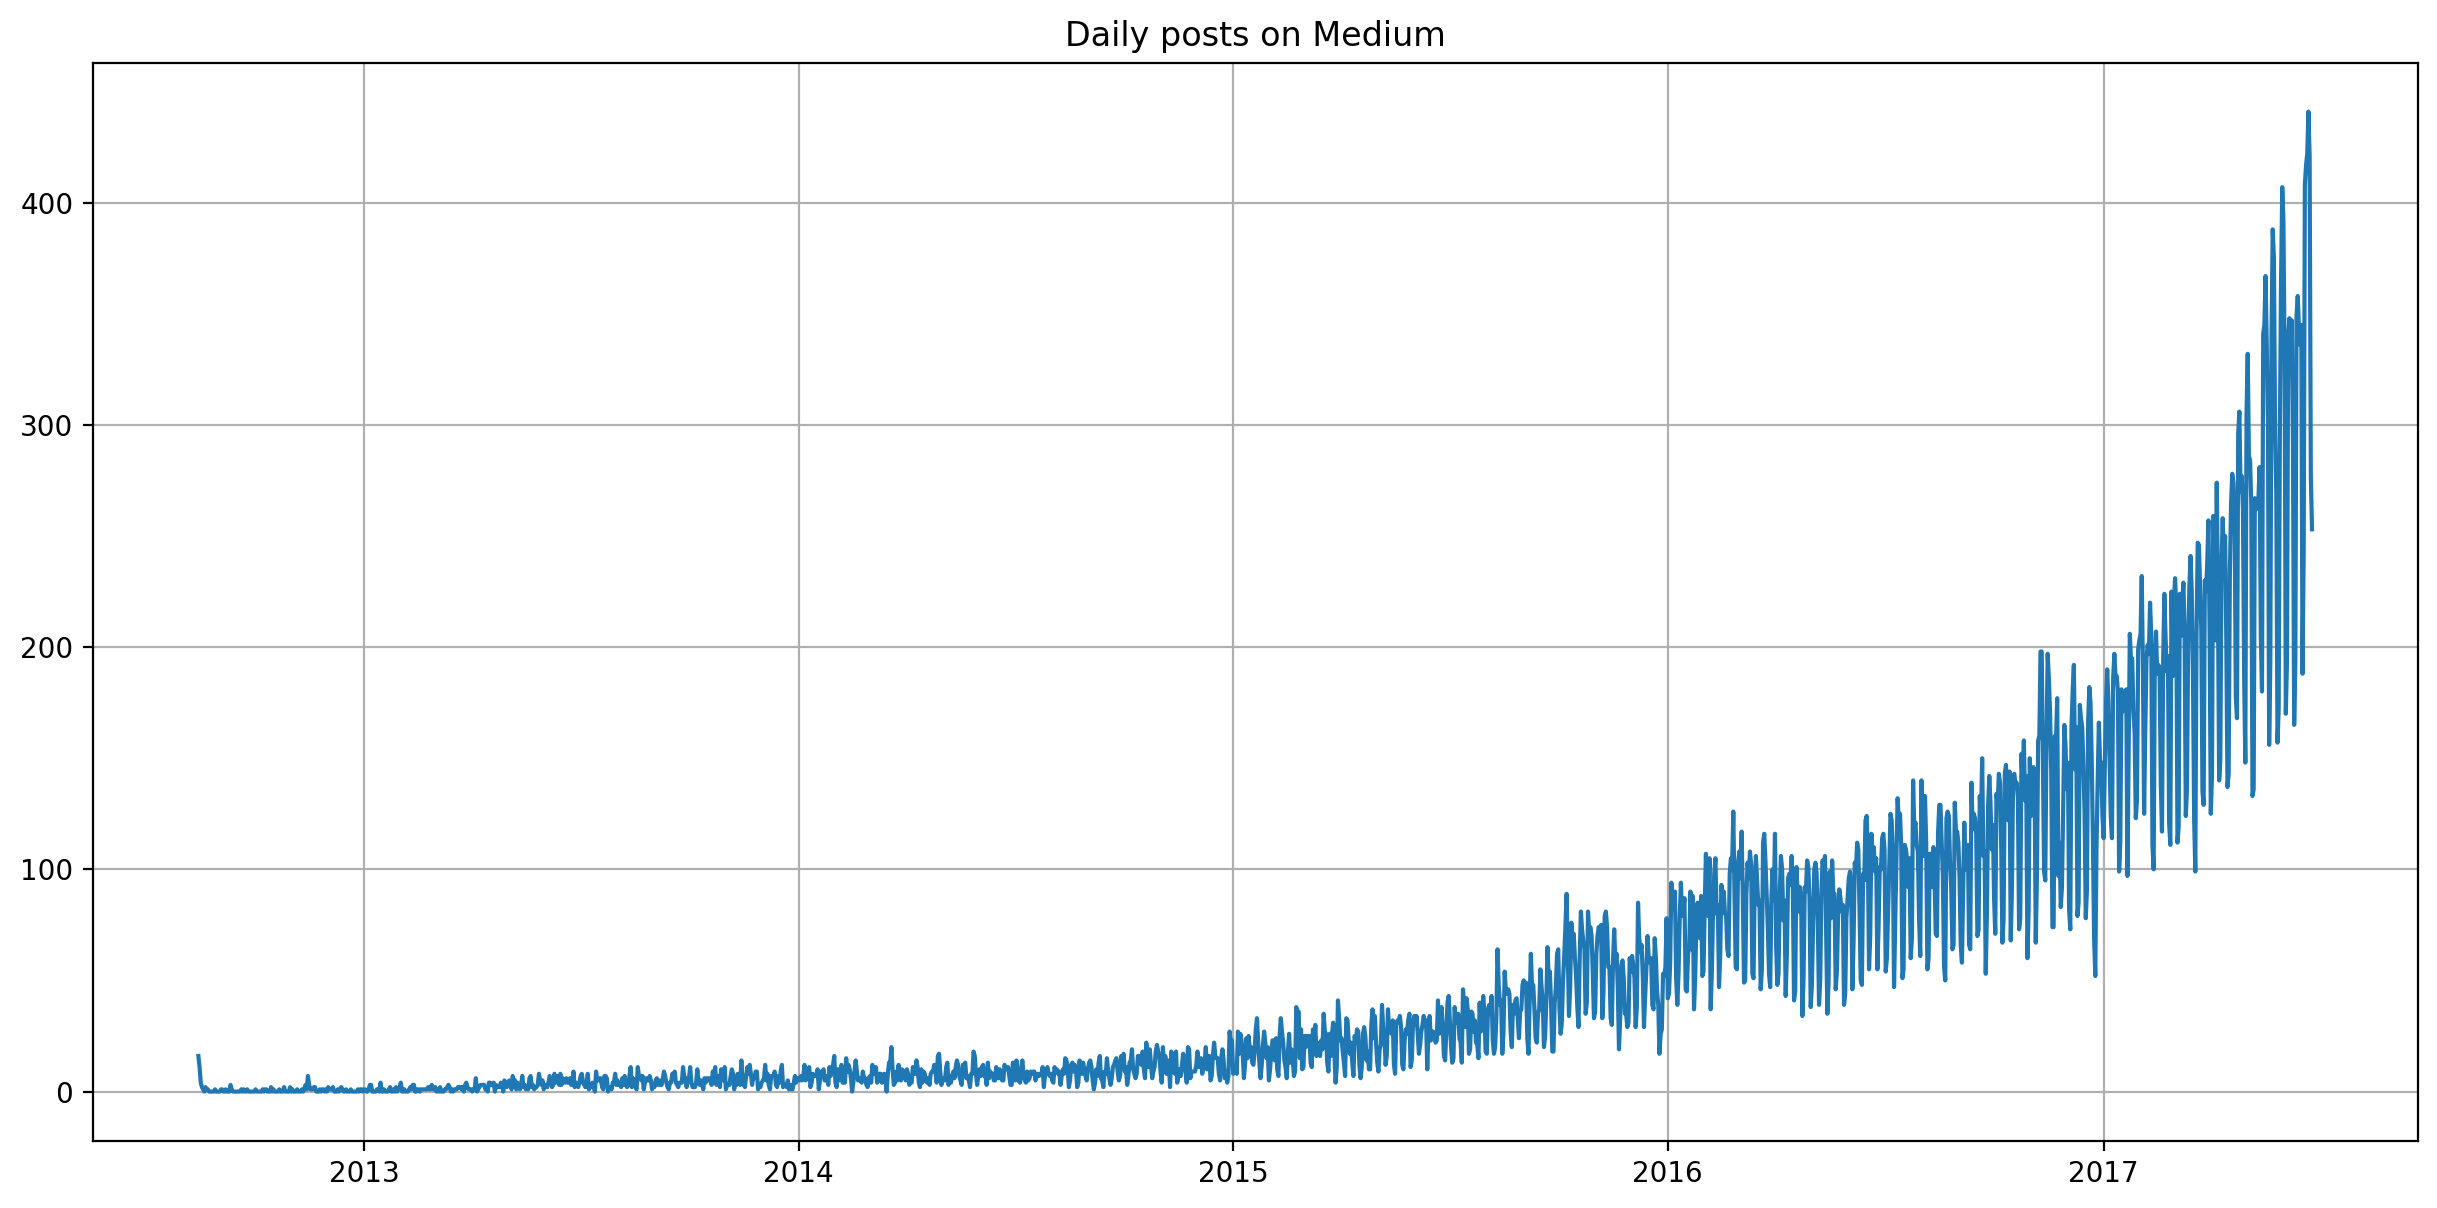

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(daily_df.posts)
plt.title('Daily posts on Medium')
plt.grid(True)
plt.show()

Уберем начало ряда - дни с малым количеством постов

In [ ]:
daily_df = daily_df.loc[daily_df.index >= '2015-01-01']
daily_df.head()

,posts
published,
2015-01-01 00:00:00+00:00,8
2015-01-02 00:00:00+00:00,11
2015-01-03 00:00:00+00:00,11
2015-01-04 00:00:00+00:00,8
2015-01-05 00:00:00+00:00,27


### Прогнозирование


In [ ]:
from prophet import Prophet

import logging
logging.getLogger().setLevel(logging.ERROR)

In [ ]:
df = daily_df.reset_index()
df.columns = ['ds', 'y']
df['ds'] = df['ds'].dt.tz_convert(None)
df.tail()

,ds,y
902,2017-06-21,422
903,2017-06-22,441
904,2017-06-23,421
905,2017-06-24,277
906,2017-06-25,253


Авторы библиотеки обычно советуют делать прогнозы на основе исторических данных как минимум за несколько месяцев, в идеале — за год.

Удалим последний месяц из набора данных, чтобы использовать его позже в качестве test-части

In [ ]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail()

,ds,y
872,2017-05-22,341
873,2017-05-23,388
874,2017-05-24,375
875,2017-05-25,298
876,2017-05-26,269


Создадим модель

In [ ]:
m = Prophet()
m.fit(train_df);

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp91_6v57z/6szvzkuv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp91_6v57z/7tsibaqe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93105', 'data', 'file=/tmp/tmp91_6v57z/6szvzkuv.json', 'init=/tmp/tmp91_6v57z/7tsibaqe.json', 'output', 'file=/tmp/tmp91_6v57z/prophet_model0mlkyh5z/prophet_model-20240220203603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:36:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:36:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Подготовим датафрейм с датами для прогнозов

In [ ]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail()

,ds
902,2017-06-21
903,2017-06-22
904,2017-06-23
905,2017-06-24
906,2017-06-25


Сделаем предсказание

In [ ]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
902,2017-06-21,276.121151,267.460577,316.753671,275.750340,276.469302,15.591731,15.591731,15.591731,17.133559,17.133559,17.133559,-1.541828,-1.541828,-1.541828,0.0,0.0,0.0,291.712882
903,2017-06-22,276.835658,263.555029,311.279792,276.443367,277.208440,11.707045,11.707045,11.707045,13.070692,13.070692,13.070692,-1.363647,-1.363647,-1.363647,0.0,0.0,0.0,288.542702
904,2017-06-23,277.550165,255.303090,304.263642,277.118958,277.949452,2.297033,2.297033,2.297033,3.474387,3.474387,3.474387,-1.177354,-1.177354,-1.177354,0.0,0.0,0.0,279.847198
905,2017-06-24,278.264671,217.628992,266.278855,277.808062,278.706815,-35.011656,-35.011656,-35.011656,-34.024377,-34.024377,-34.024377,-0.987279,-0.987279,-0.987279,0.0,0.0,0.0,243.253015
906,2017-06-25,278.979178,224.156236,270.022600,278.491581,279.460529,-31.378341,-31.378341,-31.378341,-30.580650,-30.580650,-30.580650,-0.797691,-0.797691,-0.797691,0.0,0.0,0.0,247.600837


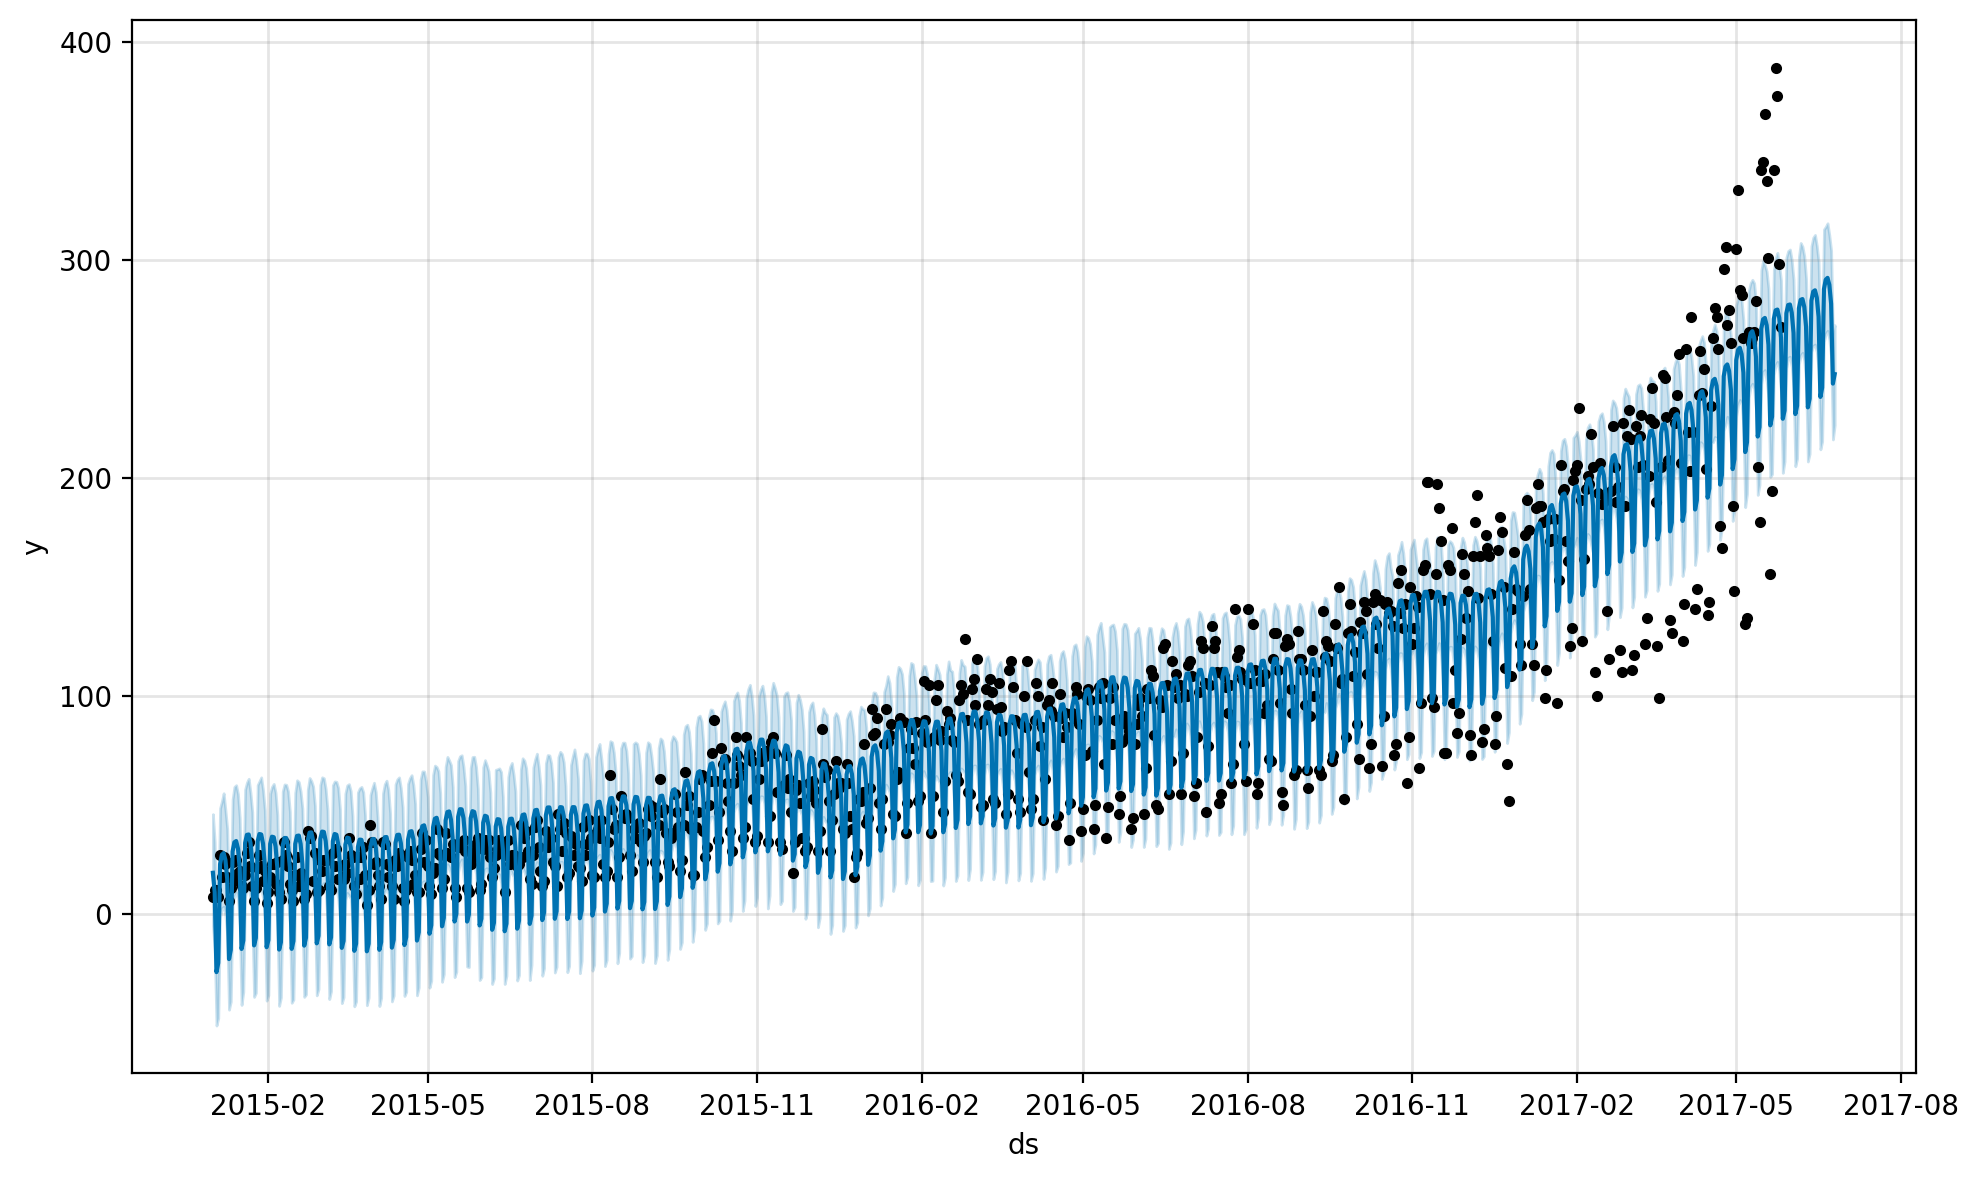

In [ ]:
m.plot(forecast);

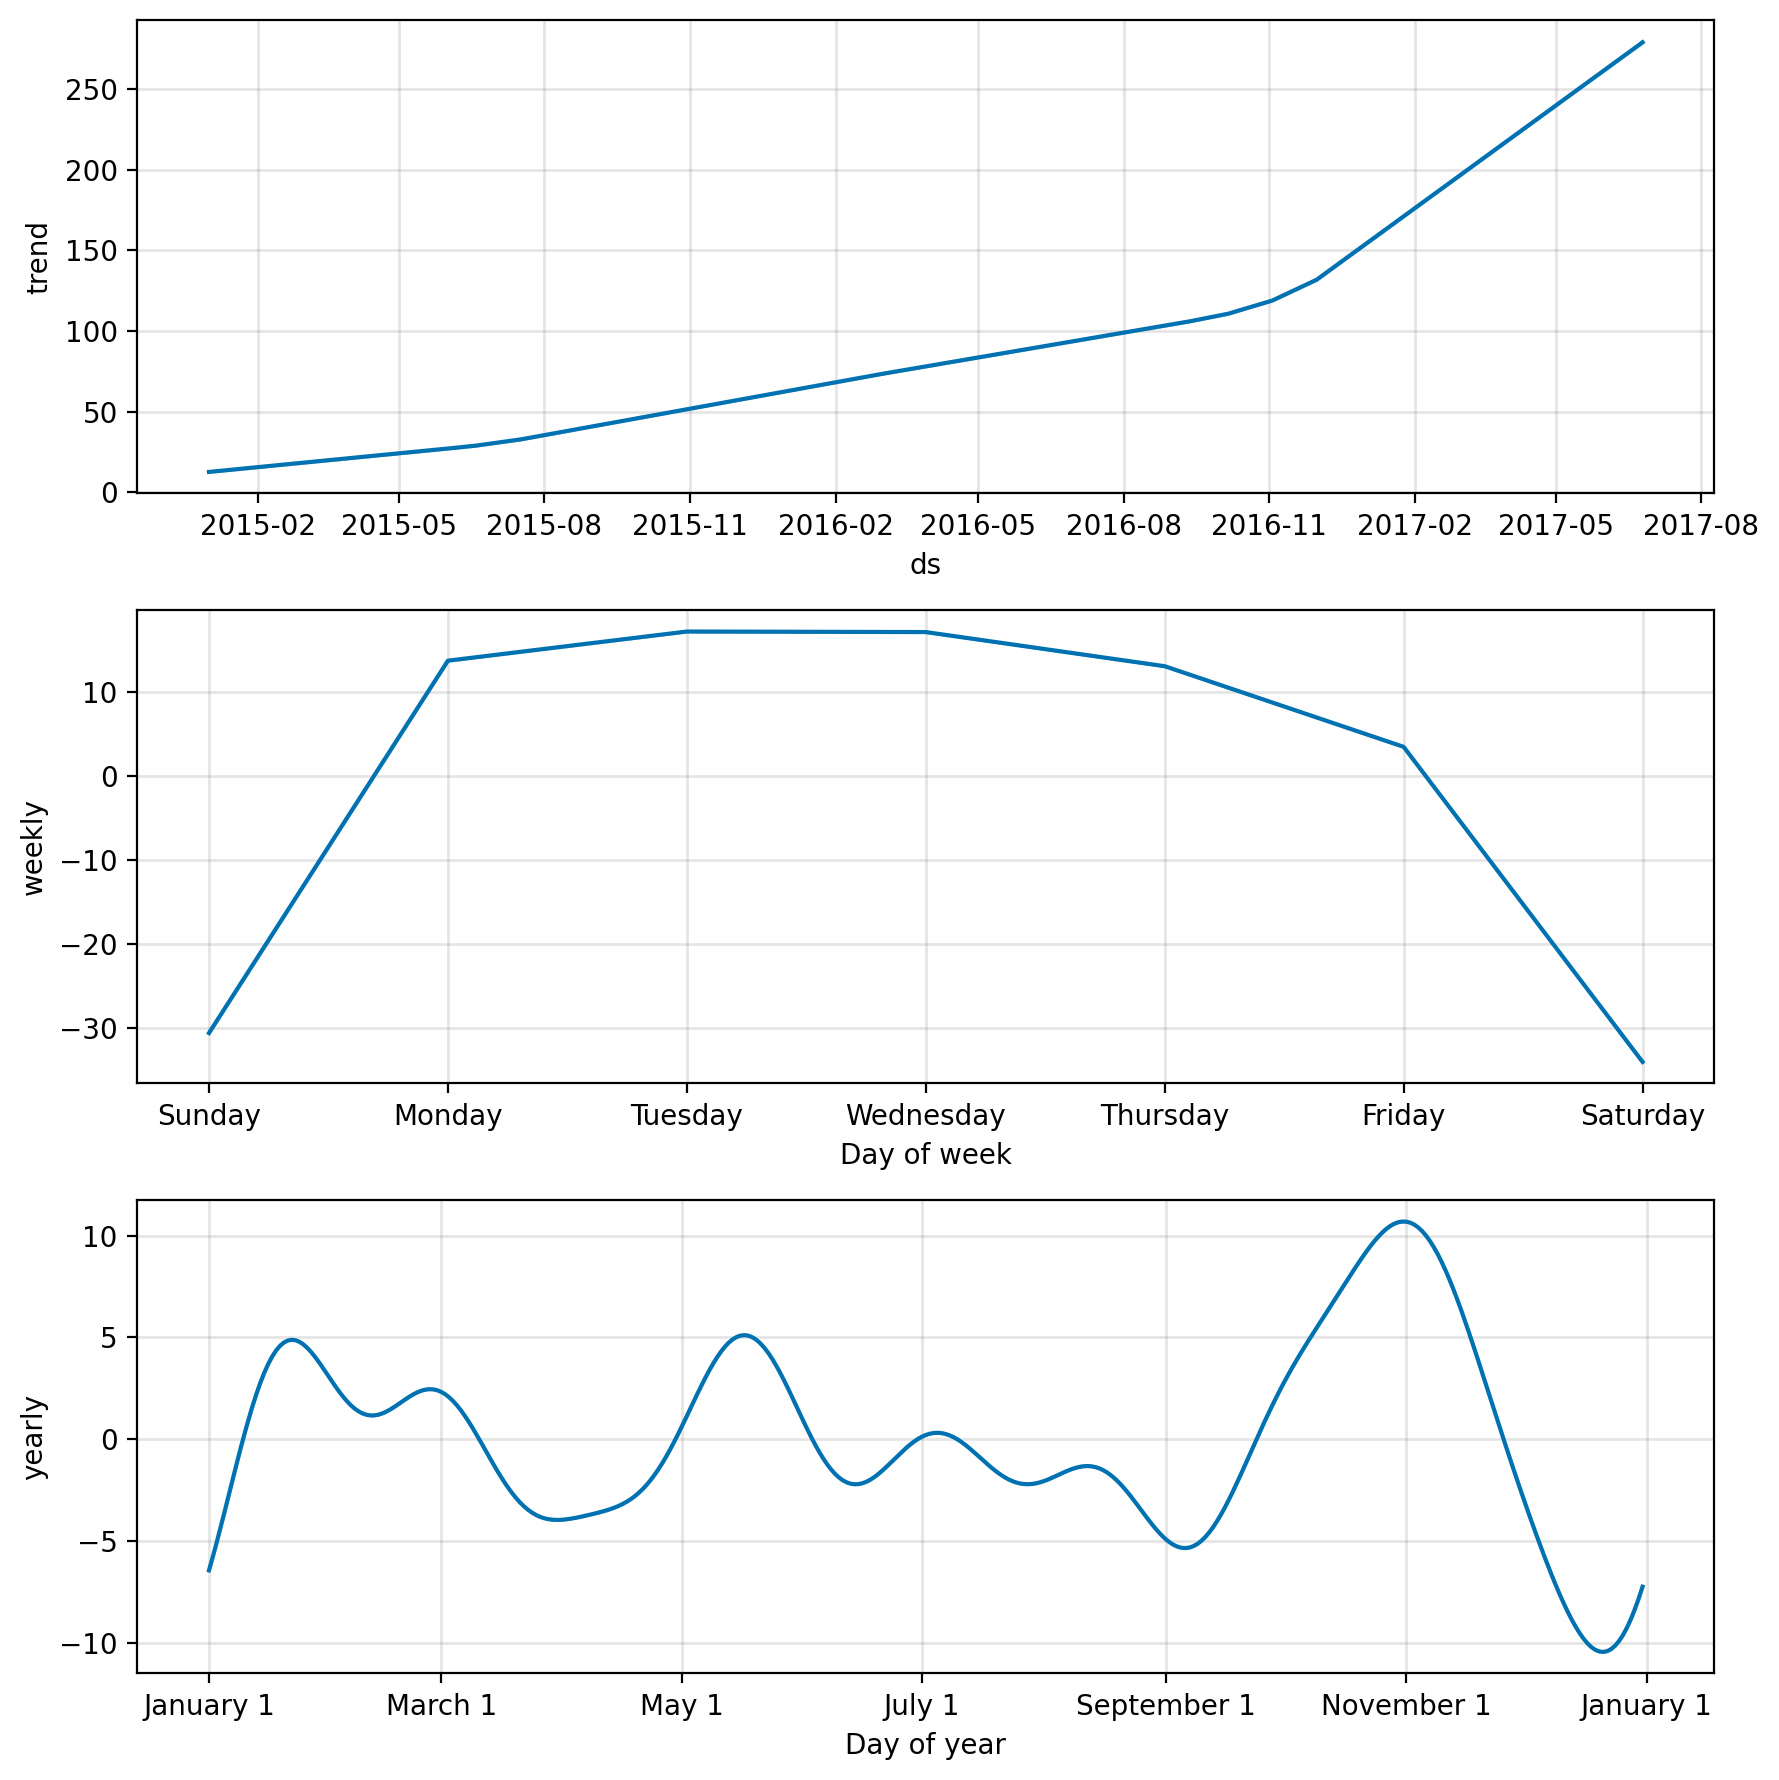

In [ ]:
m.plot_components(forecast);

### Оценка качества

In [ ]:
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


In [ ]:
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [ ]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2017-06-21,291.712882,267.460577,316.753671,422
2017-06-22,288.542702,263.555029,311.279792,441
2017-06-23,279.847198,255.303090,304.263642,421
2017-06-24,243.253015,217.628992,266.278855,277
2017-06-25,247.600837,224.156236,270.022600,253


Расчитаем метрики

In [ ]:
def calculate_forecast_errors(df, prediction_size):
    df = df.copy()

    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']

    predicted_part = df[-prediction_size:]

    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [ ]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 22.602477878539073
MAE 69.81707093439603


In [ ]:
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2015-01-01,18.950355,-5.455173,45.838954,8
2015-01-02,10.117919,-16.245478,33.232562,11
2015-01-03,-26.580601,-51.090945,-3.159759,11
2015-01-04,-22.307386,-47.642640,1.881295,8
2015-01-05,22.852484,-1.417211,48.515441,27


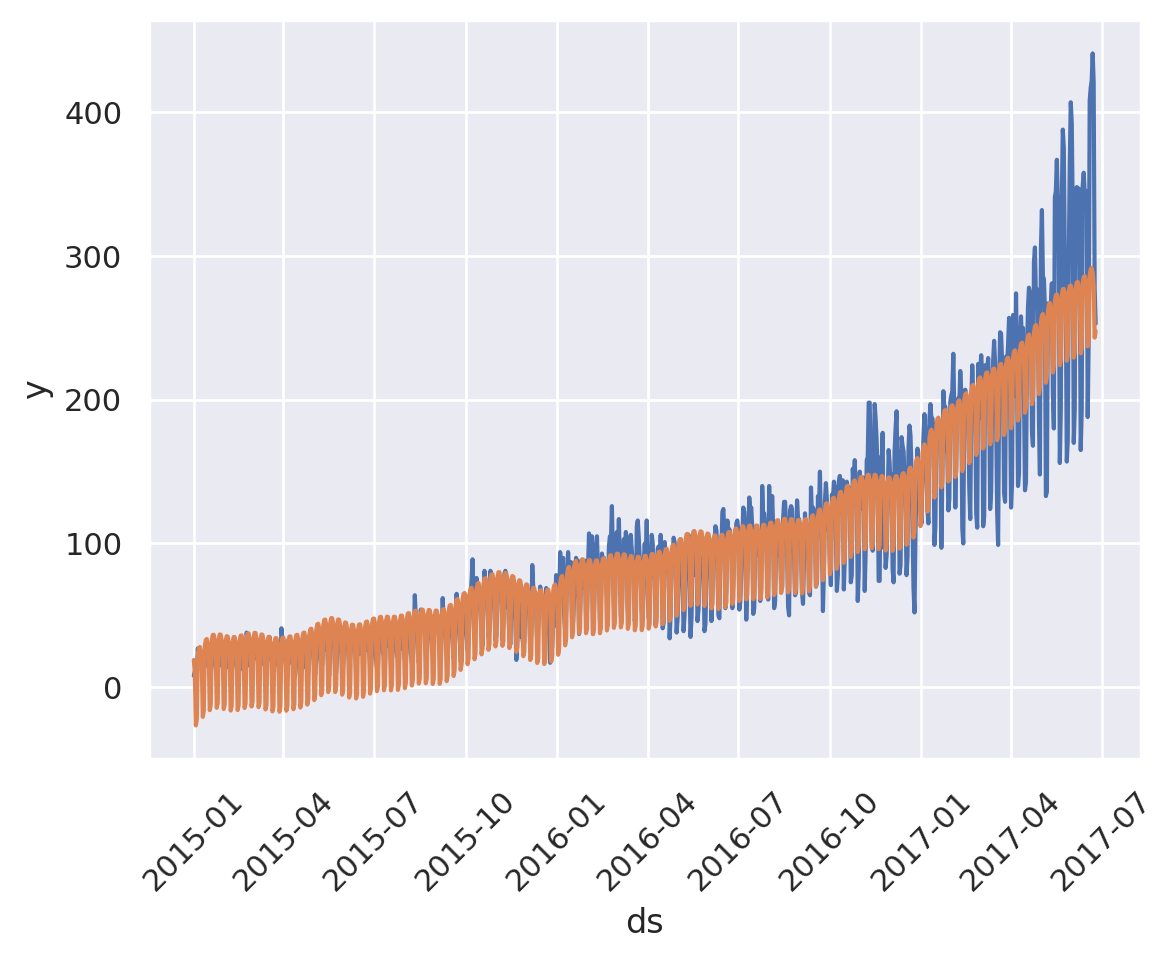

In [ ]:
plt.xticks(rotation=45)
sns.lineplot(x="ds", y="y", data=cmp_df,);
sns.lineplot(x="ds", y="yhat", data=cmp_df);

### Трансформация Бокса-Кокса


Несколько слов об этой трансформации. Это монотонное преобразование данных, которое можно использовать для стабилизации дисперсии. Мы будем использовать однопараметрическое преобразование Бокса-Кокса, которое определяется следующим выражением:

$$
\begin{equation}
  boxcox^{(\lambda)}(y_{i}) = \begin{cases}
    \frac{\displaystyle y_{i}^{\lambda} - 1}{\displaystyle \lambda} &, \text{if $\lambda \neq 0$}.\\
    ln(y_{i}) &, \text{if $\lambda = 0$}.
  \end{cases}
\end{equation}
$$

Нам нужно будет реализовать обратную эту функцию, чтобы иметь возможность восстановить исходный масштаб данных. Легко видеть, что обратное определяется как:

$$
\begin{equation}
  invboxcox^{(\lambda)}(y_{i}) = \begin{cases}
    e^{\left (\frac{\displaystyle ln(\lambda y_{i} + 1)}{\displaystyle \lambda} \right )} &, \text{if $\lambda \neq 0$}.\\
    e^{y_{i}} &, \text{if $\lambda = 0$}.
  \end{cases}
\end{equation}
$$


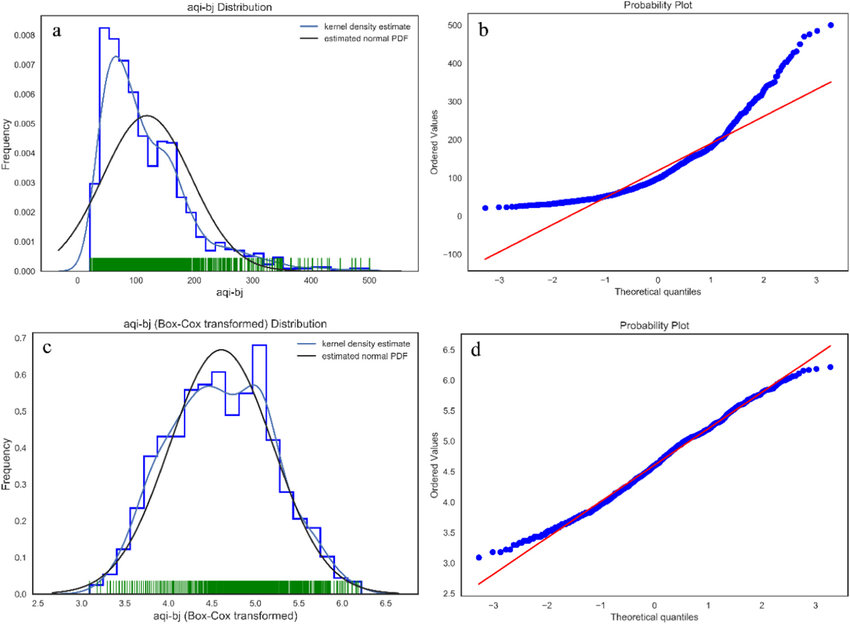

In [ ]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [ ]:
train_df2 = train_df.copy().set_index('ds')

In [ ]:
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)

In [ ]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp91_6v57z/w38g4sc4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp91_6v57z/niirvv6f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59158', 'data', 'file=/tmp/tmp91_6v57z/w38g4sc4.json', 'init=/tmp/tmp91_6v57z/niirvv6f.json', 'output', 'file=/tmp/tmp91_6v57z/prophet_modelkzwkdtq5/prophet_model-20240220204255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:42:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:42:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Обращаем трансформацию

In [ ]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

Проверяем качество

In [ ]:
cmp_df2 = make_comparison_dataframe(df, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print(err_name, err_value)

MAPE 11.588056198662485
MAE 39.058432040889514


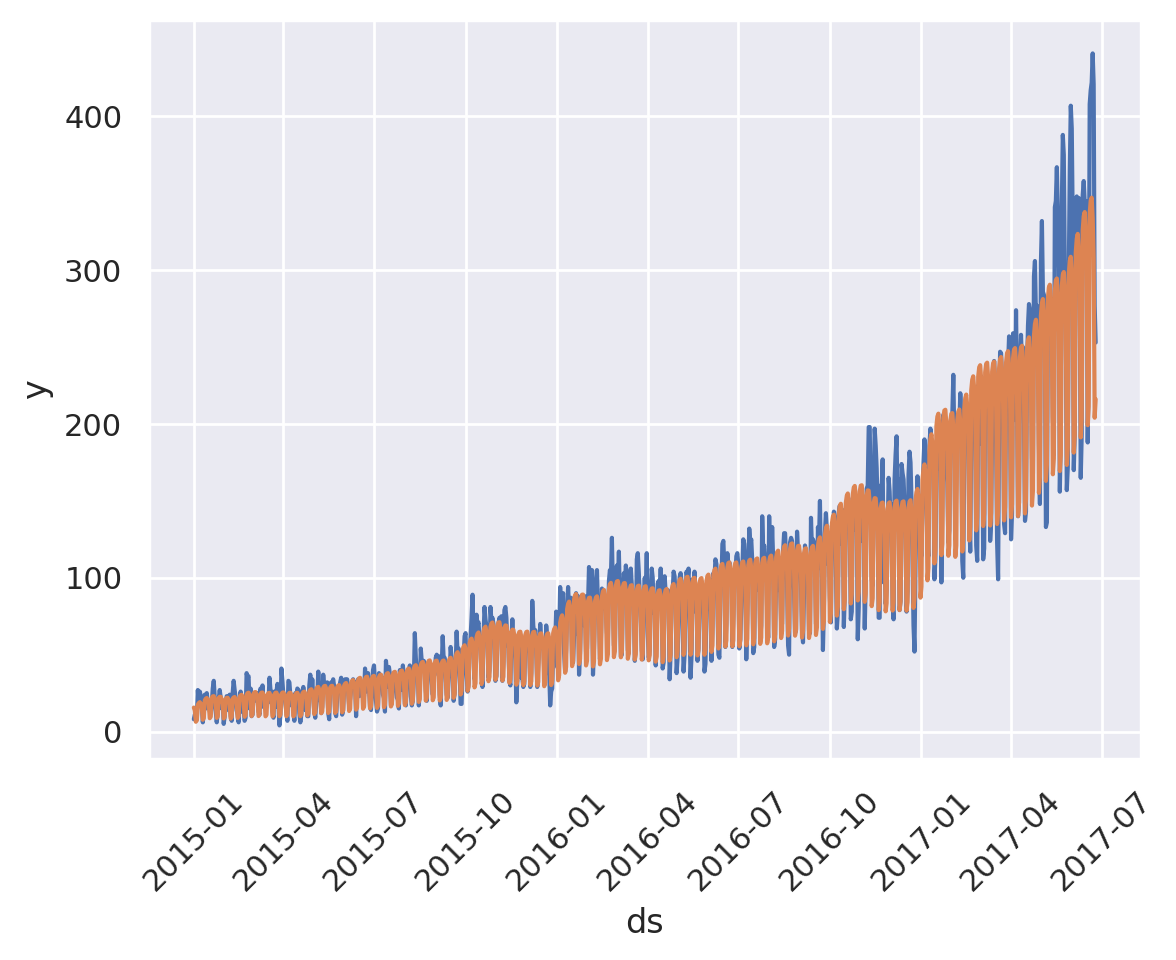

In [ ]:
plt.xticks(rotation=45)
sns.lineplot(x="ds", y="y", data=cmp_df,)
sns.lineplot(x="ds", y="yhat", data=cmp_df2);